In [14]:
import pandas as pd
import xarray as xr
import geopandas as gpd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import seaborn as sns
# mticker matplotlib
import matplotlib.ticker as mticker

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
path_shape_ipcc = f'{os.path.expanduser("~")}/OneDrive/Documentos/Shapefiles/IPCC_Regions_SA/'
AMZ_shp = f'{os.path.expanduser("~")}/OneDrive/Documentos/Shapefiles/amapoly_ivb/'
shape_AMZ_IPCC = gpd.read_file('Shape_AMZ_IPCC/IPCC_Regions_SA_AMZ.shp')
shape_IPCC = gpd.read_file(f'{path_shape_ipcc}IPCC_Regions_SA.shp')
shape_AMZ = gpd.read_file(f'{AMZ_shp}amapoly_ivb.shp')

In [3]:
# Open dataframe with the data
df = pd.read_csv('Prec_Temp_mon_AMZ.csv', sep=',')
df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d')
df['month'] = df['time'].dt.month
df

,time,Prec_NWS,Prec_NSA,Prec_SAM,Prec_NES,Temp_NWS,Temp_NSA,Temp_SAM,Temp_NES,month
0,1979-01-31,66.673030,189.022700,310.099150,302.506900,26.036070,26.149380,25.556507,26.361944,1
1,1979-02-28,73.302260,189.432250,290.668270,314.597170,25.799913,26.128927,25.437382,25.971933,2
2,1979-03-31,203.962880,287.879000,280.103030,288.933000,25.492470,26.126451,25.883392,26.696335,3
3,1979-04-30,122.605490,283.988700,132.813950,237.202040,25.304184,26.078142,25.419407,26.885412,4
4,1979-05-31,124.623985,242.134280,83.722900,125.387535,25.446030,26.212904,25.173372,26.760900,5
...,...,...,...,...,...,...,...,...,...,...
499,2020-08-31,54.016480,108.932280,19.962053,27.419626,24.345709,27.701975,26.449127,28.591280,8
500,2020-09-30,94.865730,100.540985,45.747670,37.930280,25.064516,28.226898,28.114069,28.977507,9
501,2020-10-31,82.976770,94.345260,90.541460,67.718280,25.620125,28.118454,28.207554,28.919489,10
502,2020-11-30,110.333740,155.173840,92.518330,206.400530,25.355780,27.447828,27.743420,27.953115,11


In [4]:
# Get All shapes in same crs
shape_AMZ_IPCC = shape_AMZ_IPCC.to_crs(shape_AMZ.crs)
shape_IPCC = shape_IPCC.to_crs(shape_AMZ.crs)

In [5]:
shape_IPCC

,Continent,Type,Name,Acronym,geometry
0,SOUTH-AMERICA,Land,N.W.South-America,NWS,"POLYGON ((-75.00000 12.00000, -74.57143 12.000..."
1,SOUTH-AMERICA,Land,N.South-America,NSA,"POLYGON ((-72.00000 12.00000, -71.56410 12.000..."
2,SOUTH-AMERICA,Land,N.E.South-America,NES,"POLYGON ((-34.00000 -20.00000, -34.43243 -20.0..."
3,SOUTH-AMERICA,Land,South-American-Monsoon,SAM,"POLYGON ((-66.40000 -20.00000, -66.71111 -19.7..."
4,SOUTH-AMERICA,Land,S.W.South-America,SWS,"POLYGON ((-72.00000 -15.00000, -71.68889 -15.2..."
5,SOUTH-AMERICA,Land,S.E.South-America,SES,"POLYGON ((-34.00000 -20.00000, -34.32353 -20.2..."
6,SOUTH-AMERICA,Land,S.South-America,SSA,"POLYGON ((-79.00000 -56.00000, -79.00000 -55.5..."


In [10]:
df_prec, df_temp = df[['time', 'Prec_NWS', 'Prec_NSA', 'Prec_SAM', 'Prec_NES', 'month']], df[['time', 'Temp_NWS', 'Temp_NSA', 'Temp_SAM', 'Temp_NES', 'month']]

In [104]:
# Mean Climatology
prec_clim = df_prec.groupby('month').mean().reset_index()
temp_clim = df_temp.groupby('month').mean().reset_index()

# Std Climatology
prec_std = df_prec.groupby('month').std().reset_index()
temp_std = df_temp.groupby('month').std().reset_index()

temp_std = temp_std.drop(columns=['month'], axis=1).mean()

In [176]:
# Plot data 2
def plot_data_box(prec_clim, prec_mon, data_prec, temp_clim, temp_std, ax, legend=False):

    sns.boxplot(x='month', y=prec_mon.values,
                data=data_prec, ax=ax, color='k', 
                boxprops={'alpha': 1}, medianprops={'color': 'none'}, width=.05, 
                linewidth=1., fliersize=0)
    # sns.barplot(x='month', y=prec_mon.values, data=data_prec, ax=ax, 
    #     color='navy', alpha=.5,  linewidth=50, capsize=.2) # capsize=.2
    ax.bar(prec_clim.index, prec_clim.values,
           color='navy', label='Precipitation', alpha=.5)
    # Set xticks
    ax.set_xticks(np.arange(0, 12))
    # Set xtickslabels to month names
    month_names = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
    ax.set_xticklabels(month_names)
    # Set color of yticks
    ax.tick_params(axis='y', colors='navy')
    # Set color yticks labels
    ax.yaxis.label.set_color('navy')
    ax.set_ylabel('', color='firebrick')


    # Twins axis
    ax2 = ax.twinx()
    ax2.plot(temp_clim.index, temp_clim.values, marker='o', markersize=6, markeredgecolor='white', color='firebrick', label='Temperature')
    # fill_between std
    ax2.fill_between(temp_clim.index, temp_clim.values-temp_std, temp_clim.values+temp_std, color='firebrick', alpha=.1)
    
    ax2.set_ylabel('', color='firebrick')
    ax.set_xlabel('')
    #ax2.set_xticks(np.arange(1, 13))
    #ax2.set_xticklabels(month_names)

    # Set yticks
    ax2.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))
    # Set color of yticks
    ax2.tick_params(axis='y', colors='firebrick')
    # Set color of ytickslabels
    ax2.yaxis.label.set_color('firebrick')

    # Same scale for both y axes
    ax.set_ylim(0, 500)
    ax.set_yticks(np.arange(0, 500 + 100, 100))
    ax2.set_ylim(22, 30)
    #ax2.set_yticks(np.arange(0, 36, 8))

    if legend:
    # Set legend to two axes
       handles, labels = ax.get_legend_handles_labels()
       handles2, labels2 = ax2.get_legend_handles_labels()
       ax.legend(handles + handles2, labels + labels2, loc='upper left', frameon=False, bbox_to_anchor=(-0.2, 1.4), fontsize=11)

In [177]:
# fig, ax = plt.subplots(figsize=(8, 5))
# plot_data_box(prec_clim['Prec_NWS'], df_prec['Prec_NWS'], df_prec, temp_clim['Temp_NWS'], temp_std['Temp_NWS'], ax, legend=False)

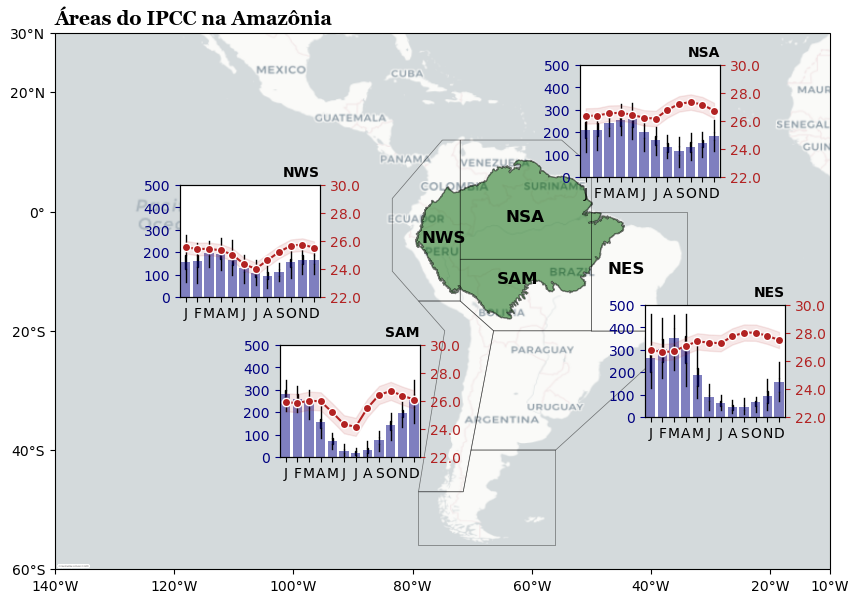

In [236]:
proj = ccrs.PlateCarree(central_longitude=0) # projection - 140W
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=proj), gridspec_kw=dict(hspace=0))
# Extent of south america
# ax.set_extent([140, 380, -30, 30], crs=ccrs.PlateCarree()) # W, E, S, N
ax.set_extent([-140, -10, -60, 30], crs=ccrs.PlateCarree()) # W, E, S, N
# Add shapefile
shape_AMZ.plot(ax=ax, facecolor='darkgreen', edgecolor='black', lw=1., alpha=0.5, transform=ccrs.PlateCarree())
shape_IPCC.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.5, alpha=0.5, transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.75)


# Add text to IPCC regions in center of each region
for i, txt in enumerate(shape_AMZ_IPCC['Acronym']):
    if txt == 'NES':
        ax.text(shape_AMZ_IPCC.geometry[i].centroid.x + 4, shape_AMZ_IPCC.geometry[i].centroid.y - 6, txt, 
            fontsize=12, ha='center', fontweight='bold',
            va='center', transform=proj)
    else:
        ax.text(shape_AMZ_IPCC.geometry[i].centroid.x, shape_AMZ_IPCC.geometry[i].centroid.y, txt, 
                fontsize=12, ha='center', fontweight='bold',
                va='center', transform=proj)

# Basemap
ctx.add_basemap(ax, crs=ccrs.PlateCarree(), source=ctx.providers.CartoDB.Positron,
                     attribution_size=0)

# Basemap
# ax.stock_img()

# Basemap
# ax.background_img(name='BM', resolution='high')

# # Add plots of precipitation and temperature
ax2 = fig.add_axes([0.65, 0.65, 0.14, 0.14]) # left, bottom, width, height
plot_data_box(prec_clim['Prec_NSA'], df_prec['Prec_NSA'], df_prec, temp_clim['Temp_NSA'], temp_std['Temp_NSA'], ax2, legend=False)
# Set title
ax2.set_title('NSA', fontsize=10, fontweight='bold', loc='right')
ax3 = fig.add_axes([0.35, 0.3, 0.14, 0.14]) # left, bottom, width, height
plot_data_box(prec_clim['Prec_SAM'], df_prec['Prec_SAM'], df_prec, temp_clim['Temp_SAM'], temp_std['Temp_SAM'], ax3, legend=False)
# Set title
ax3.set_title('SAM', fontsize=10, fontweight='bold', loc='right')
ax4 = fig.add_axes([0.25, 0.5, 0.14, 0.14]) # left, bottom, width, height
plot_data_box(prec_clim['Prec_NWS'], df_prec['Prec_NWS'], df_prec, temp_clim['Temp_NWS'], temp_std['Temp_NWS'], ax4, legend=False)
# Set title
ax4.set_title('NWS', fontsize=10, fontweight='bold', loc='right')
ax5 = fig.add_axes([0.715, 0.35, 0.14, 0.14]) # left, bottom, width, height
plot_data_box(prec_clim['Prec_NES'], df_prec['Prec_NES'], df_prec, temp_clim['Temp_NES'], temp_std['Temp_NES'], ax5, legend=False)
# Set title
ax5.set_title('NES', fontsize=10, fontweight='bold', loc='right')

# Add ticks
ax.set_xticks([-140, -120, -100, -80, -60, -40, -20, -10])
ax.set_yticks([-60, -40, -20, 0, 20, 30])
# Add tick labels
ax.set_xticklabels(['140°W', '120°W', '100°W', '80°W', '60°W', '40°W', '20°W', '10°W']);
ax.set_yticklabels(['60°S', '40°S', '20°S', '0°', '20°N', '30°N']);

# Set title
ax.set_title('Áreas do IPCC na Amazônia', fontsize=14, fontweight='bold', loc='left', fontname='Georgia')

# # Salvar figura
fig.savefig('Map_Amazon.png', dpi=600, bbox_inches='tight')

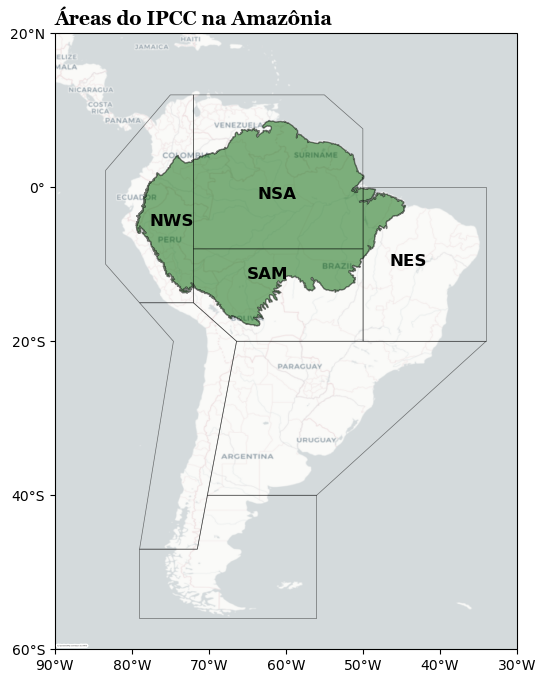

In [243]:
proj = ccrs.PlateCarree(central_longitude=0) # projection - 140W
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=proj), gridspec_kw=dict(hspace=0))
# Extent of south america
ax.set_extent([-90, -30, -60, 20], crs=ccrs.PlateCarree()) # W, E, S, N
# Add shapefile
shape_AMZ.plot(ax=ax, facecolor='darkgreen', edgecolor='black', lw=1., alpha=0.5, transform=ccrs.PlateCarree())
shape_IPCC.plot(ax=ax, facecolor='none', edgecolor='black', lw=0.5, alpha=0.5, transform=ccrs.PlateCarree())
# ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.75)


# Add text to IPCC regions in center of each region
for i, txt in enumerate(shape_AMZ_IPCC['Acronym']):
    if txt == 'NES':
        ax.text(shape_AMZ_IPCC.geometry[i].centroid.x + 4, shape_AMZ_IPCC.geometry[i].centroid.y - 6, txt, 
            fontsize=12, ha='center', fontweight='bold',
            va='center', transform=proj)
    else:
        ax.text(shape_AMZ_IPCC.geometry[i].centroid.x, shape_AMZ_IPCC.geometry[i].centroid.y, txt, 
                fontsize=12, ha='center', fontweight='bold',
                va='center', transform=proj)

# Basemap
ctx.add_basemap(ax, crs=ccrs.PlateCarree(), source=ctx.providers.CartoDB.Positron,
                     attribution_size=0)


# # Add ticks
ax.set_xticks([-90, -80, -70, -60, -50, -40, -30])
ax.set_yticks([-60, -40, -20, 0, 20])
# # Add tick labels
ax.set_xticklabels(['90°W', '80°W', '70°W', '60°W', '50°W', '40°W', '30°W']);
ax.set_yticklabels(['60°S', '40°S', '20°S', '0°', '20°N']);

# Set title
ax.set_title('Áreas do IPCC na Amazônia', fontsize=14, fontweight='bold', loc='left', fontname='Georgia')

# # Salvar figura
fig.savefig('Map_Amazon_2.png', dpi=600, bbox_inches='tight')